In [123]:
from importlib import reload
import utils; reload(utils)
import classes; reload(classes)
import os
import sys
import numpy as np
import pandas as pd

In [124]:
# Load data and print out useful info
from utils import load_titanic
x, y = load_titanic('data/train.csv')

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [240]:
# Import classifiers
clfs = classes.Classifiers(verbose=0, method='random', num_clf=3)

Sampling 3 algorithms from complete inventory.
Metod: 'random'


# Fitting and tuning of parameters

We need a way of optimizing the hyper parameters of each selected algorithm. 

## Regular fitting (just train)

This is the basic building block: "fit_classifiers" loops over each algorithm and trains on data

In [116]:
# Fit classifiers on data
clfs.fit_classifiers(x,y,-1)

C:\Users\magaxels\AppData\Local\Continuum\Anaconda3\envs\pandaupdate\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\magaxels\AppData\Local\Continuum\Anaconda3\envs\pandaupdate\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Implement cross validation

In [257]:
from sklearn.svm import SVC
svc = SVC()

In [259]:
svc.__init__()

In [241]:
estimators = clfs.clf # list of estimators
estimators

array([ SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False),
       RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)], dtype=object)

In [139]:
for estimator in estimators[0:1]:
    print(estimator.get_params())
    default_params = estimator.get_params()
    estimator.set_params(**{'n_neighbors':10, 'leaf_size':50})
    print(estimator.get_params())

{'metric': 'minkowski', 'algorithm': 'auto', 'n_neighbors': 10, 'n_jobs': 1, 'p': 2, 'metric_params': None, 'weights': 'uniform', 'leaf_size': 30}
{'metric': 'minkowski', 'algorithm': 'auto', 'n_neighbors': 10, 'n_jobs': 1, 'p': 2, 'metric_params': None, 'weights': 'uniform', 'leaf_size': 50}


In [145]:
type(1.0), type(1), type('auto'), type(None), type(1e-07), type(True)

(float, int, str, NoneType, float, bool)

In [175]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
param_names_ = knn._get_param_names()
print(param_names_)
doc = knn.__doc__

['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']


In [260]:
import re 
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
doc = knn.__doc__ # Get the doc string
#from sklearn.svm import SVC
#svc = SVC()
#doc = svc.__doc__
pattern = "([a-zA-Z_]+\s:\s)|(-\s*)'([a-zA-Z_]+)'" # Define search pattern
re.compile(pattern)
matches = re.findall(pattern, doc)
#print(matches)

In [261]:
from pprint import pprint 
clf_params = {}
previous_param = ''
for param, sep, value in matches:
    if ":" in param and param[-4]!="_": # 'Hack-y'
        if param not in clf_params.keys():
            clf_params[param] = list()
        previous_param = param
    else:
        if len(value)>0:
            clf_params[previous_param].append(value)
pprint(clf_params)

{'algorithm : ': ['ball_tree', 'kd_tree', 'brute', 'auto'],
 'leaf_size : ': [],
 'metric : ': [],
 'metric_params : ': [],
 'n_jobs : ': [],
 'n_neighbors : ': [],
 'p : ': [],
 'weights : ': ['uniform', 'distance']}


In [248]:
print(doc)

C-Support Vector Classification.

    The implementation is based on libsvm. The fit time complexity
    is more than quadratic with the number of samples which makes it hard
    to scale to dataset with more than a couple of 10000 samples.

    The multiclass support is handled according to a one-vs-one scheme.

    For details on the precise mathematical formulation of the provided
    kernel functions and how `gamma`, `coef0` and `degree` affect each
    other, see the corresponding section in the narrative documentation:
    :ref:`svm_kernels`.

    Read more in the :ref:`User Guide <svm_classification>`.

    Parameters
    ----------
    C : float, optional (default=1.0)
        Penalty parameter C of the error term.

    kernel : string, optional (default='rbf')
         Specifies the kernel type to be used in the algorithm.
         It must be one of 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or
         a callable.
         If none is given, 'rbf' will be used. If a cal

## Tune hyper parameters using cross validation

In [117]:
# Predict on data (returns a list of (name, prediction) tuples for each classifier in repository)
preds = clfs.predict_classifiers(x)
clfs.verbose = 1 # Report progress if =1, else be quiet if =0.
# How well are we doing?
scores = clfs.classifier_performance(preds, y, metric='accuracy')

In [119]:
clfs.clf

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
               loss='hinge', n_iter=5, n_jobs=-1, random_state=None,
               shuffle=True, verbose=0, warm_start=False),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_s

## Check correlations

In [7]:
# Create an instance "correlation checking" classes
import classes; reload(classes)
check = classes.CheckClassifierCorrelation(prediction_type='c_binary')
# Get names and correlation matrix
names_, corr_ = check.compute_correlation_matrix(preds)
# Plot correlation matrix (output depends on if plotting inline or not)
fig = check.plot_correlation_matrix(names_, corr_, fig_size=(11,11), font_scale=1.1, file=os.getcwd()+"/corr.png")

Saving figure to 'C:\users\magaxels\Desktop\Ad hoc\ML meta wrapper project/corr.png'


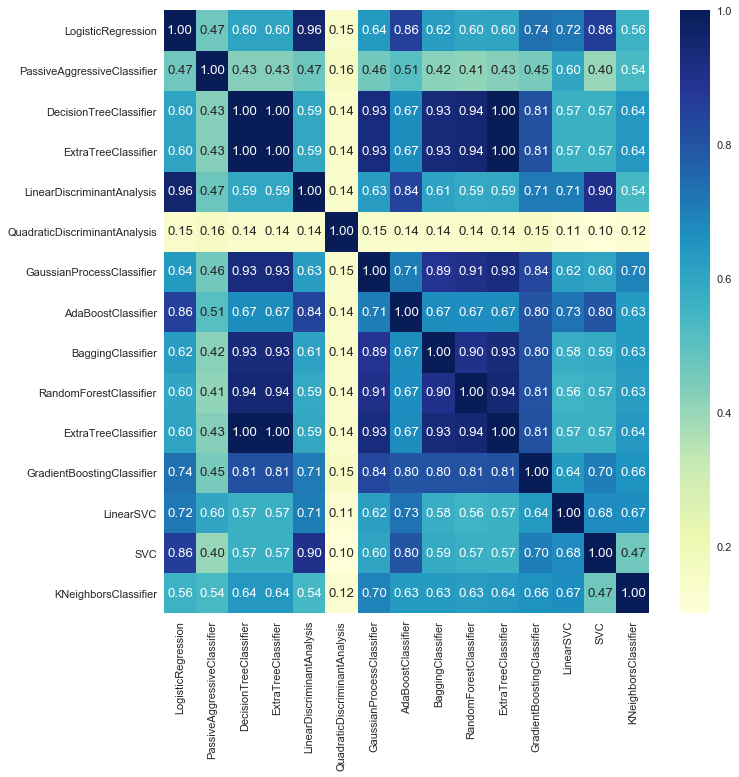

In [8]:
fig